In [1]:
## ESSENTIAL for imports and directories --> put it in every notebook in subfolders of src
%cd ..

c:\Users\ceresini_m\github\Thesis\src


In [2]:
import os, glob, pickle
from tqdm import tqdm
import numpy as np
from typing import Literal
import pandas as pd
import matplotlib.pyplot as plt

from config_pckg.config_file import Config

C:\Users\ceresini_m\AppData\Local\Temp\ipykernel_13788\4283466360.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
conf = Config()
meshComplete_paths = glob.glob(os.path.join(conf.EXTERNAL_FOLDER_MESHCOMPLETE_W_LABELS, "*.pkl"))

# for filename in conf.problematic_files: # used if getting objects from EXTERNAL_FOLDER_MESHCOMPLETE without labels
#     meshComplete_paths.remove(os.path.join(conf.EXTERNAL_FOLDER_MESHCOMPLETE_W_LABELS, filename+".pkl"))

In [4]:
meshComplete_objs = []

for path in tqdm(meshComplete_paths):
    with open(path, "rb") as f:
        meshComplete_objs.append(pickle.load(f))

  0%|          | 0/146 [00:00<?, ?it/s]

100%|██████████| 146/146 [01:02<00:00,  2.32it/s]


In [5]:
def get_interesting_info(obj_list, mode:Literal["geometry", "labels"] = "geometry"):

    match mode:
        case "geometry":
            interesting_df = pd.DataFrame({
                "n_points": [m.mesh.points.shape[0] for m in obj_list],
                "n_faces": [m.face_center_positions.shape[0] for m in obj_list],
                "n_cells": [m.cell_center_positions.shape[0] for m in obj_list],
                "n_CcCc_edges": [m.CcCc_edges_bidir.shape[0]/2 for m in obj_list],
                "n_FcFc_edges": [m.FcFc_edges.shape[0] for m in obj_list],
                "n_CcFc_edges": [m.CcFc_edges.shape[0] for m in obj_list],
                "avg_vertices_in_face": [np.mean([len(face_vertices) for face_vertices in m.vertices_in_faces]) for m in obj_list],
                "avg_vertices_in_cell": [np.mean([len(cell_vertices) for cell_vertices in m.vertices_in_cells]) for m in obj_list],
                "group": [1 if "2dtc_001R" in m.path else 2 for m in obj_list]
            })

        case "labels":
            interesting_df = pd.DataFrame({
                col: [m.face_center_labels[col].mean() for m in obj_list] 
                    for col in obj_list[0].face_center_labels.columns})
            interesting_df["group"] = [1 if "2dtc_001R" in m.path else 2 for m in obj_list]
            
    return interesting_df


In [6]:
pd.set_option('display.float_format', '{:.2g}'.format)

In [7]:
info_complete = get_interesting_info(meshComplete_objs)
info_complete.describe()

,n_points,n_faces,n_cells,n_CcCc_edges,n_FcFc_edges,n_CcFc_edges,avg_vertices_in_face,avg_vertices_in_cell,group
count,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02,1.5e+02
mean,2.1e+04,4.3e+04,2.1e+04,4.1e+04,1.2e+05,8.3e+04,2,3.9,1.7
std,3.3e+03,6.5e+03,3.2e+03,6.2e+03,1.9e+04,1.3e+04,0,0.042,0.47
min,1.5e+04,3.2e+04,1.6e+04,3e+04,8.7e+04,6.2e+04,2,3.8,1
25%,1.7e+04,3.4e+04,1.7e+04,3.2e+04,9.6e+04,6.6e+04,2,3.9,1
50%,2.3e+04,4.7e+04,2.4e+04,4.5e+04,1.3e+05,9.2e+04,2,3.9,2
75%,2.4e+04,4.7e+04,2.4e+04,4.5e+04,1.4e+05,9.2e+04,2,3.9,2
max,2.4e+04,4.7e+04,2.4e+04,4.5e+04,1.4e+05,9.3e+04,2,3.9,2


In [8]:
def boxplot_by(df, by):
    chosen_columns = list(df.columns.difference(["group", "split"]))
    fig, axs = plt.subplots(1,len(chosen_columns), figsize=(20, 7))
    for i, column in enumerate(chosen_columns):
        axs[i].tick_params("y", direction="in", pad=0, labelsize=7, labelrotation=90)
        df.boxplot(column, ax=axs[i], by=by)

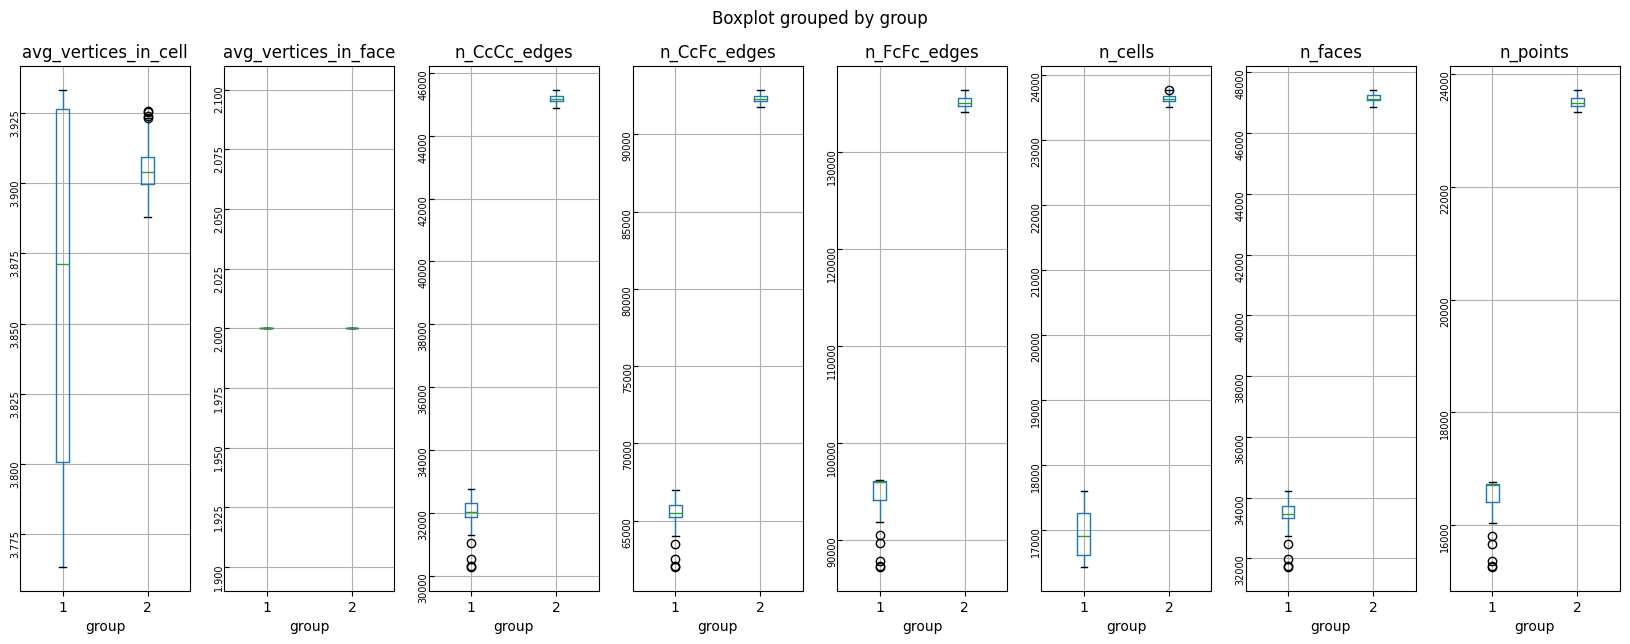

In [9]:
boxplot_by(info_complete, "group")

In [10]:
def get_splits_from_idxs(idxs, splits=(0.8, 0.1)):
    train_split = list(np.random.choice(list(idxs), 
                                   int(np.floor(splits[0]*len(idxs))),
                                   replace=False))
    val_split = list(np.random.choice(list(idxs.difference(set(train_split))), 
                                 int(np.floor(splits[1]*len(idxs))),
                                 replace=False))
    test_split = list(idxs.difference(set(train_split)).difference(set(val_split)))

    return train_split, val_split, test_split

def generate_train_val_test_splits(info_complete, splits=(0.8, 0.1)):
    flap1_idxs = set(np.arange(len(info_complete))[info_complete["group"]==1])
    train_flap1, val_flap1, test_flap1 = get_splits_from_idxs(flap1_idxs, splits)
    flap2_idxs = set(np.arange(len(info_complete))[info_complete["group"]==2])
    train_flap2, val_flap2, test_flap2 = get_splits_from_idxs(flap2_idxs, splits)

    train_split = train_flap1 + train_flap2
    val_split = val_flap1 + val_flap2
    test_split = test_flap1 + test_flap2

    split_type = pd.api.types.CategoricalDtype(ordered= True, categories=["train", "val", "test"])
    split_series = pd.Series(np.zeros_like(info_complete["group"]))
    split_series[train_split] = "train"
    split_series[val_split] = "val"
    split_series[test_split] = "test"
    split_series = split_series.astype(split_type)
    
    return split_series


In [11]:
split_series = generate_train_val_test_splits(info_complete)
split_series.value_counts()

train    116
test      17
val       13
Name: count, dtype: int64

In [12]:
info_complete["split"] = split_series

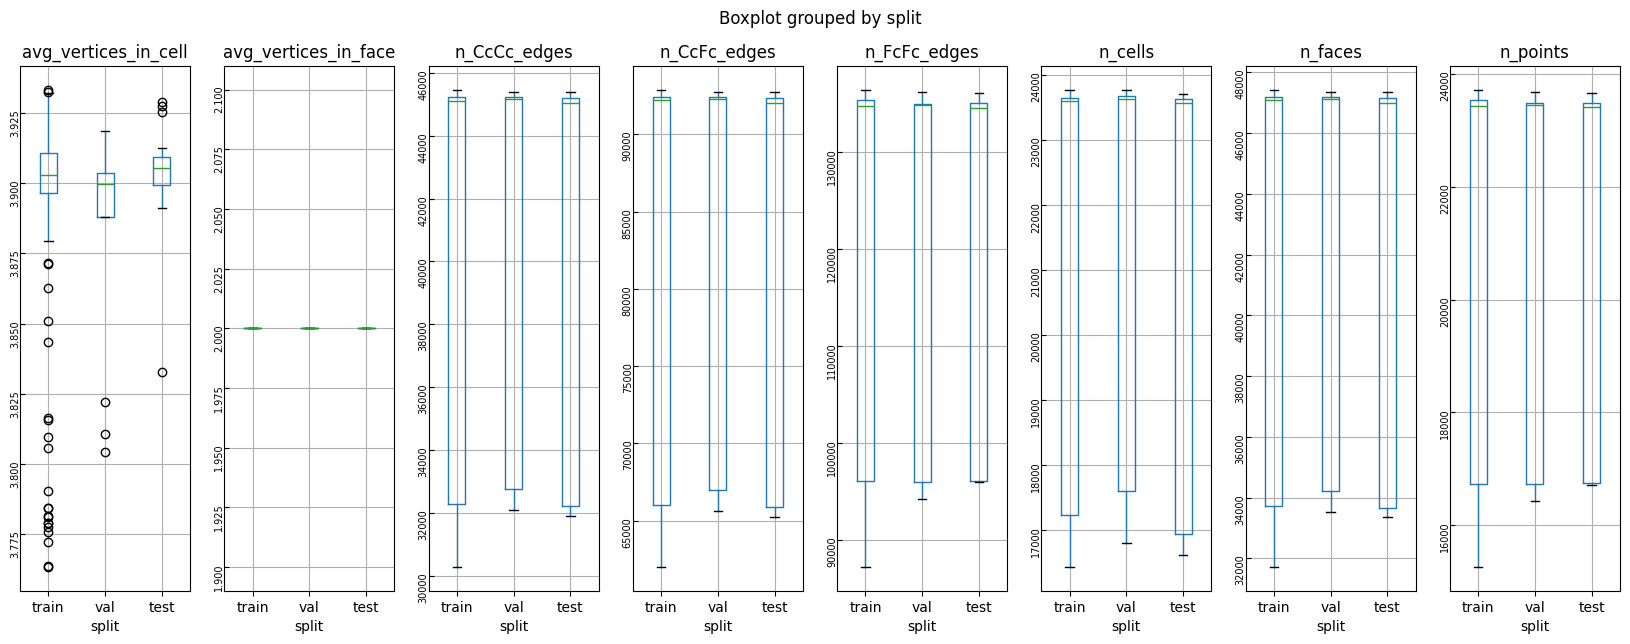

In [13]:
boxplot_by(info_complete, "split")

In [14]:
# errors = []
# for meshComplete_obj in (pbar := tqdm(meshComplete_objs)):
#     try:
#         name = meshComplete_obj.path.split(os.sep)[-1].removesuffix(".pkl")
#         pbar.set_description(name)
#         last_csv = glob.glob(os.path.join(conf.EXTERNAL_FOLDER_CSV, name+"*_at300.csv"))
#         if len(last_csv) == 1:
#             path_csv = last_csv[0]
#         meshComplete_obj.add_labels(path_csv)
#     except Exception as e:
#         print(e, name)
#         errors.append(name)

In [15]:
# from scipy.spatial.distance import cdist
# pts = meshComplete_objs[0].mesh.points
# m = cdist(pts, pts)
# ma = np.ma.masked_array(m, mask=np.eye(m.shape[0]))
# np.min(ma)

In [16]:
label_info = get_interesting_info(meshComplete_objs, mode="labels")
label_info["split"] = split_series

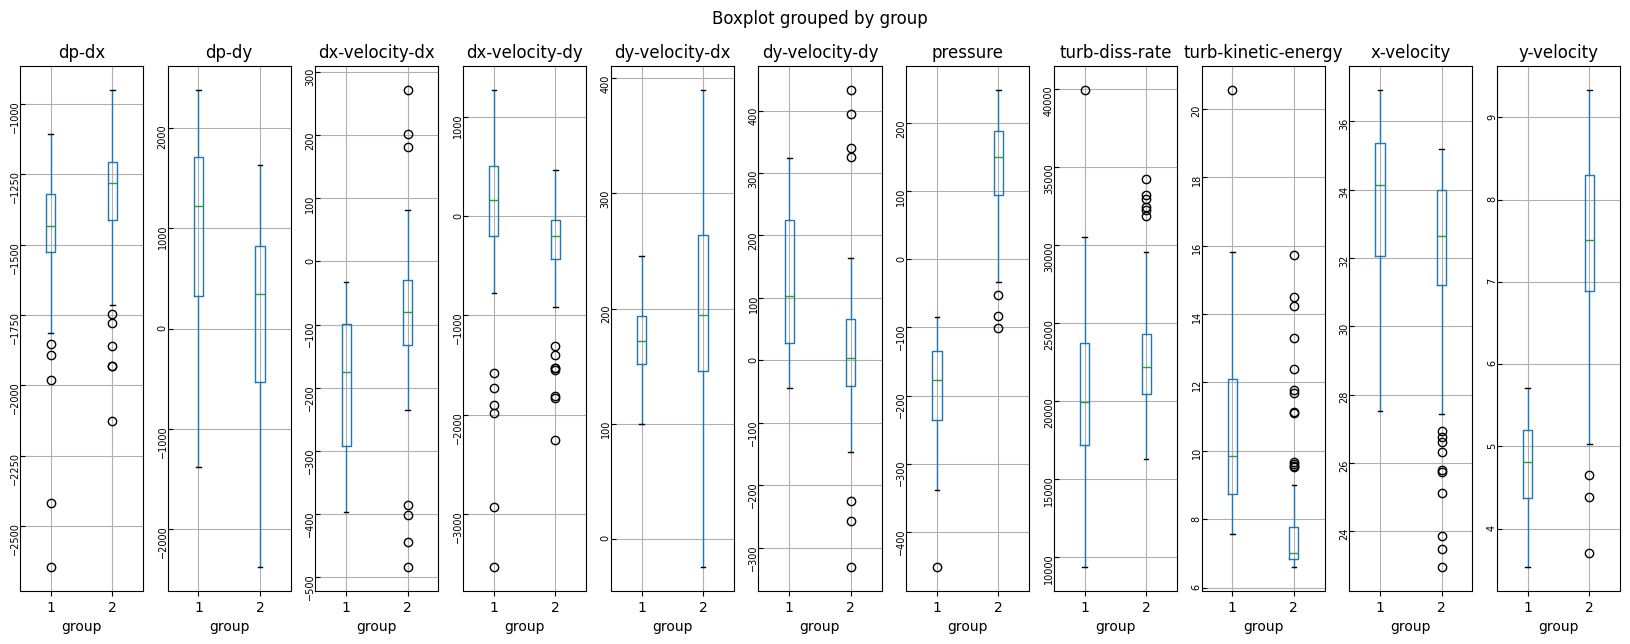

In [17]:
boxplot_by(label_info, "group")

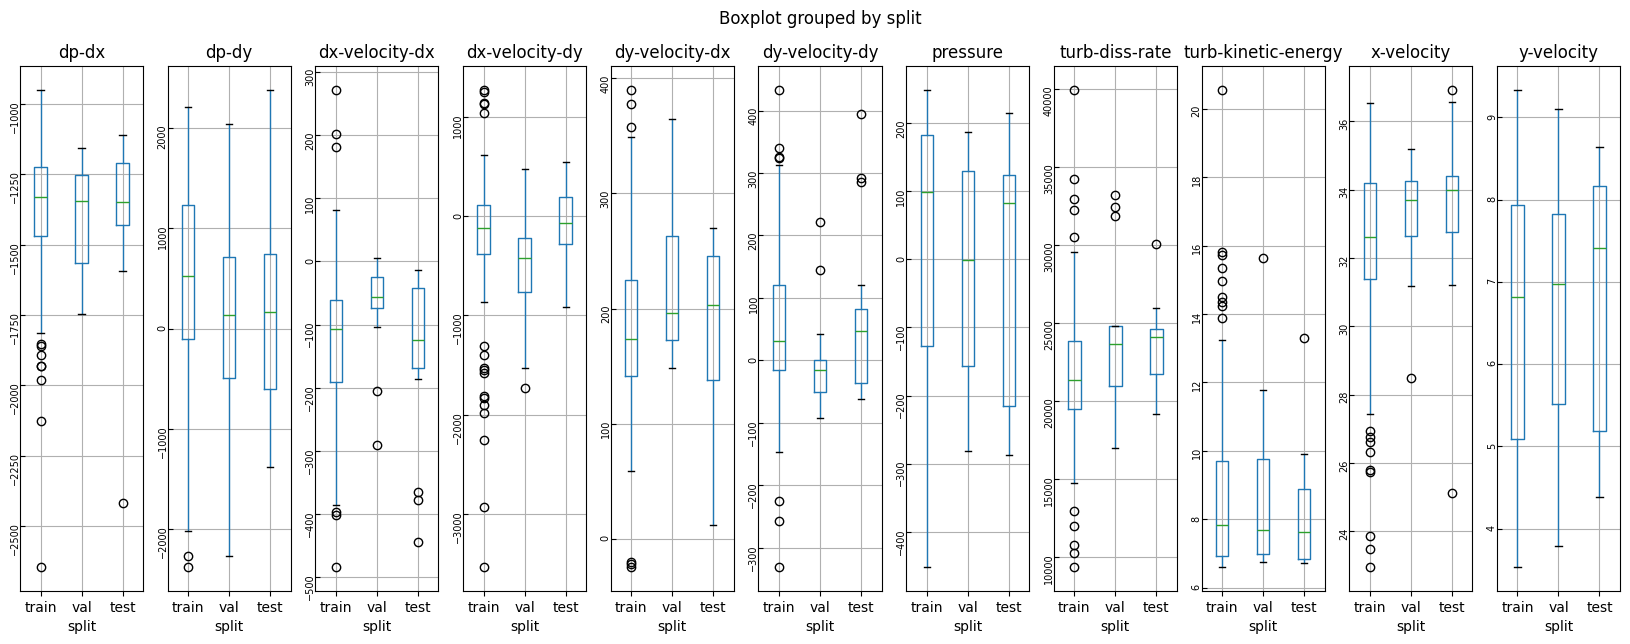

In [18]:
boxplot_by(label_info, "split")